# Setting Up Environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Getting the Train Data

**The Dataset has been downloaded from Kaggle**

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X_train = train_data.drop(labels = 'Survived',axis = 1)
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
y_train = train_data['Survived']
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Cleaning up the Train Input Data and Adding new Columns(i.e. Features)

**Checking for Outliers**

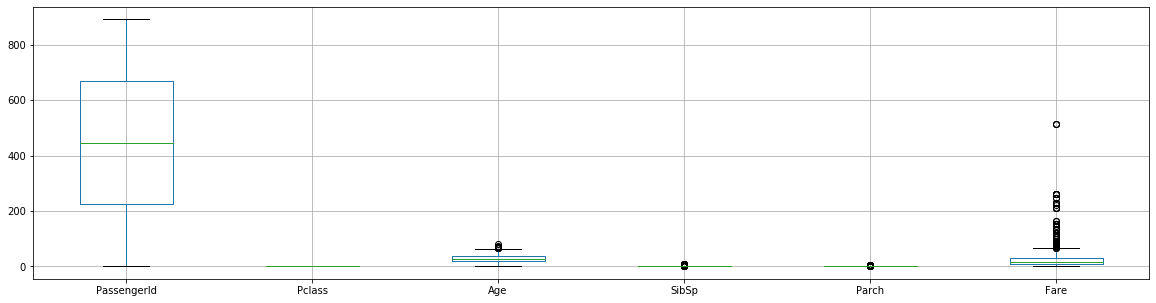

In [5]:
plt.figure(figsize=(20,5))
X_train.boxplot()

In [6]:
def detect_outliers(df,n,features):
    """
    This function basically takes a dataframe, that contains everything about the features.
      And returs list of index of Observations if it possesses more than n outliers.
    """
    outlier_index = []          # n+1 -> minimum number of outliers
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.75 * IQR
        
        # Determine a list of index of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_index.extend(outlier_list_col)
        
    # select observations containing more than n outliers
    outlier_index = Counter(outlier_index)        
    more_than_n_outliers = list( k for k, v in outlier_index.items() if v > n )
    
    return more_than_n_outliers
  
outlier_examples = detect_outliers(X_train,2,X_train[['Pclass','Age','SibSp','Parch','Fare']])

print('Outlier Rows: ', outlier_examples)

Outlier Rows:  [27, 88, 341]


C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [7]:
X_train.iloc[outlier_examples]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
88,89,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
341,342,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S


**Checking the number of Null Values in each Column**

In [8]:
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Getting the Honorifics from the Names**





In [9]:
train_honorifics = X_train['Name'].str.split(pat = ', ',expand = True)[1].str.split(pat = '.',expand = True)[0]
print("Unique Honorifics: ", train_honorifics.unique())

Unique Honorifics:  ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


In [10]:
train_honorifics = train_honorifics.replace(to_replace = ['Ms','Mlle'],value = 'Miss')
train_honorifics = train_honorifics.replace(to_replace = ['Mme'],value = 'Mrs')
train_honorifics = train_honorifics.replace(to_replace=['Capt','Col','Major','Dr','Rev'],value='Officers')

In [11]:
train_honorifics_counts = train_honorifics.value_counts()
train_honorifics_counts

Mr              517
Miss            185
Mrs             126
Master           40
Officers         18
Don               1
Jonkheer          1
the Countess      1
Lady              1
Sir               1
Name: 0, dtype: int64

In [12]:
train_honorifics = train_honorifics.apply(lambda x: 'Royalty' if train_honorifics_counts[x] < 5 else x) 
print("After Replacing, Unique Honorifics: ", train_honorifics.unique())

After Replacing, Unique Honorifics:  ['Mr' 'Mrs' 'Miss' 'Master' 'Royalty' 'Officers']


 **Adding the 'Honorifics' column**

In [13]:
X_train['Honorifics'] = train_honorifics

**Filling the Missing Ages**

In [14]:
train_group_age = X_train.groupby(['Honorifics','Sex'])['Age'].mean()
train_group_age

Honorifics  Sex   
Master      male       4.574167
Miss        female    21.845638
Mr          male      32.368090
Mrs         female    35.788991
Officers    female    49.000000
            male      46.562500
Royalty     female    40.500000
            male      42.333333
Name: Age, dtype: float64

In [15]:
def newage (cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=="male":
            return 4.57
        elif title=='Miss' and Sex=='female':
            return 21.8
        elif title=='Mr' and Sex=='male': 
            return 32.37
        elif title=='Mrs' and Sex=='female':
            return 35.72
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.56
        elif title=='Royalty' and Sex=='female':
            return 40.50
        else:
            return 42.33
    else:
        return Age    

In [16]:
X_train['Age']=X_train[['Honorifics','Sex','Age']].apply(newage, axis=1)

**Replacing the Null values in Columns having Real values with their respective median values**

In [17]:
medians = X_train.median(axis = 0)
medians

PassengerId    446.0000
Pclass           3.0000
Age             30.0000
SibSp            0.0000
Parch            0.0000
Fare            14.4542
dtype: float64

In [18]:
for col in medians.index:
    X_train[col].fillna(value = medians[col],inplace = True)

**Filling the NaN values in 'Embarked' with the mode of the column**

In [19]:
mode_embarked = X_train['Embarked'].mode()[0]
print(mode_embarked)

S


In [20]:
X_train['Embarked'].fillna(value = mode_embarked,inplace = True)

**Replacing NaN values in 'Cabin' with 'Unknow'**

In [21]:
X_train['Cabin'].fillna('Unknow',inplace = True)

**Adding 'len_Ticket' , 'len_Cabin'  and 'Relatives'**

In [22]:
X_train['len_Ticket'] = X_train['Ticket'].apply(lambda x: len(x))

In [23]:
X_train['len_Cabin'] = X_train['Cabin'].apply(lambda x: len(x))

In [24]:
X_train['Relatives'] = X_train['SibSp'] + X_train['Parch']

In [25]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorifics,len_Ticket,len_Cabin,Relatives
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknow,S,Mr,9,6,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,8,3,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S,Miss,16,6,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,6,4,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknow,S,Mr,6,6,0


**Dropping the unncessary columns**

In [26]:
temp_Train = X_train.copy()
temp_Train['Survived'] = y_train
temp_Train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorifics,len_Ticket,len_Cabin,Relatives,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknow,S,Mr,9,6,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,8,3,1,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S,Miss,16,6,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,6,4,1,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknow,S,Mr,6,6,0,0


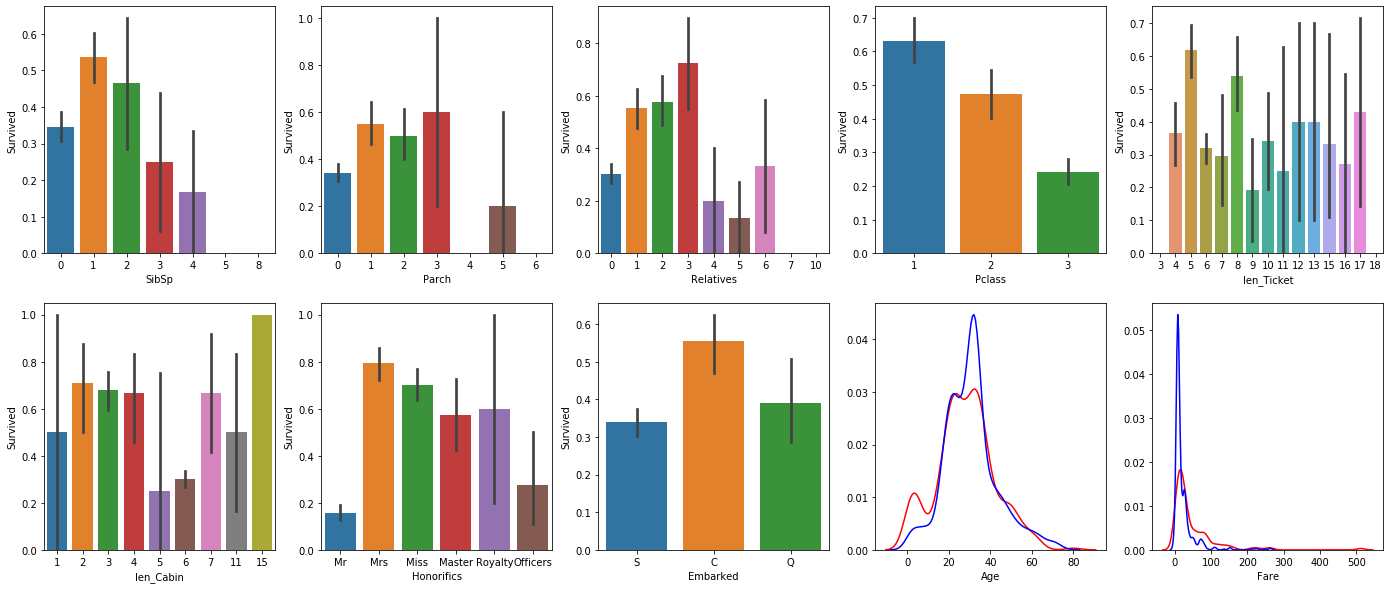

In [27]:
plt.figure(figsize = (24,10))

plt.subplot(2,5,1)
sns.barplot(x = 'SibSp', y = 'Survived', data = temp_Train)

plt.subplot(2,5,2)
sns.barplot(x = 'Parch',y = 'Survived', data = temp_Train)

plt.subplot(2,5,3)
sns.barplot(x = 'Relatives', y = 'Survived', data = temp_Train)

plt.subplot(2,5,4)
sns.barplot(x = 'Pclass', y ='Survived', data = temp_Train)
 
plt.subplot(2,5,5)
sns.barplot(x = 'len_Ticket', y = 'Survived', data = temp_Train)

plt.subplot(2,5,6)
sns.barplot(x = 'len_Cabin', y = 'Survived', data = temp_Train)

plt.subplot(2,5,7)
sns.barplot(x = 'Honorifics', y = 'Survived', data = temp_Train)

plt.subplot(2,5,8)
sns.barplot(x = 'Embarked', y = 'Survived', data = temp_Train)

plt.subplot(2,5,9)
sns.distplot(temp_Train[temp_Train['Survived'] == 1]['Age'], hist = False, color = 'red')
sns.distplot(temp_Train[temp_Train['Survived'] == 0]['Age'], hist = False,color = 'blue')

plt.subplot(2,5,10)
sns.distplot(temp_Train[temp_Train['Survived'] == 1]['Fare'],hist = False,color = 'red')
sns.distplot(temp_Train[temp_Train['Survived'] == 0]['Fare'],hist = False,color = 'blue')

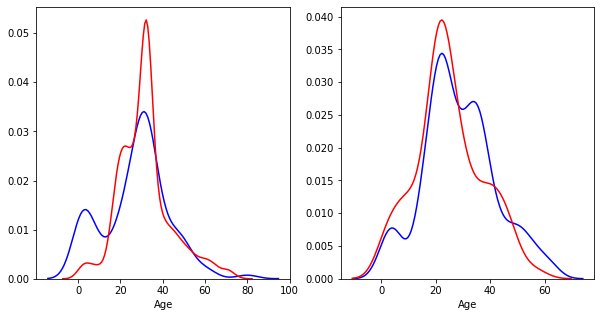

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(temp_Train[ (temp_Train['Sex'] == 'male') & (temp_Train['Survived'] == 1) ]['Age'],hist = False,color = 'blue')
sns.distplot(temp_Train[ (temp_Train['Sex'] == 'male') & (temp_Train['Survived'] == 0) ]['Age'],hist = False,color = 'red')

plt.subplot(1,2,2)
sns.distplot(temp_Train[ (temp_Train['Sex'] == 'female') & (temp_Train['Survived'] == 1) ]['Age'],hist = False,color = 'blue')
sns.distplot(temp_Train[ (temp_Train['Sex'] == 'female') & (temp_Train['Survived'] == 0) ]['Age'],hist = False,color = 'red')

In [29]:
X_train.drop(labels = ['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis = 1, inplace = True)
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Honorifics,len_Ticket,len_Cabin,Relatives
0,3,male,22.0,7.2500,S,Mr,9,6,1
1,1,female,38.0,71.2833,C,Mrs,8,3,1
2,3,female,26.0,7.9250,S,Miss,16,6,0
3,1,female,35.0,53.1000,S,Mrs,6,4,1
4,3,male,35.0,8.0500,S,Mr,6,6,0


# One-Hot encoding the Train Data

In [30]:
X_train = pd.get_dummies(X_train)

#Label 'Female' as 1 and 'Male' as 0 
X_train.drop(labels = 'Sex_male',axis = 1,inplace = True )
X_train.rename(columns={'Sex_female':'Sex'},inplace=True)
X_train.head()

,Pclass,Age,Fare,len_Ticket,len_Cabin,Relatives,Sex,Embarked_C,Embarked_Q,Embarked_S,Honorifics_Master,Honorifics_Miss,Honorifics_Mr,Honorifics_Mrs,Honorifics_Officers,Honorifics_Royalty
0,3,22.0,7.2500,9,6,1,0,0,0,1,0,0,1,0,0,0
1,1,38.0,71.2833,8,3,1,1,1,0,0,0,0,0,1,0,0
2,3,26.0,7.9250,16,6,0,1,0,0,1,0,1,0,0,0,0
3,1,35.0,53.1000,6,4,1,1,0,0,1,0,0,0,1,0,0
4,3,35.0,8.0500,6,6,0,0,0,0,1,0,0,1,0,0,0


**I also experimented with MinMaxScaler and StandardScaler to scale the input data before fitting the models. However, none of them led to any increase in the score of the models, so I decided to not use them.**

# Fitting Various Classification Models

**Random Forest**

In [31]:
rfc = RandomForestClassifier(random_state = 42)
rfc_params = dict(
    max_depth = [n for n in range(8, 14)],     
    min_samples_split = [n for n in range(3, 11)], 
    min_samples_leaf = [n for n in range(2, 6)],     
    n_estimators = [n for n in range(10, 100, 10)],
    criterion = ['gini','entropy'])    

In [32]:
rfc_cv = GridSearchCV(estimator = rfc, param_grid = rfc_params, cv=5)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [33]:
print("Best score: {}".format(rfc_cv.best_score_))
print("Optimal params: {}".format(rfc_cv.best_estimator_))

Best score: 0.8484848484848485
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


**Gradient Boosting Classifier**

In [34]:
gbc = GradientBoostingClassifier(random_state = 42)
gbc_params = dict(
        loss= ['deviance','exponential'],
        learning_rate= [0.01, 0.1, 1, 10],
        n_estimators= [10, 25, 50, 100], 
        min_samples_split= [2, 3, 4, 5],
        min_samples_leaf= [1, 2, 3],
        max_depth= [6, 7, 8, 9])

In [35]:
gbc_cv = GridSearchCV(estimator = gbc, param_grid = gbc_params, cv =5)
gbc_cv.fit(X_train,y_train)

C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  subsample=1.0, tol

In [36]:
print("Best score: {}".format(gbc_cv.best_score_))
print("Optimal params: {}".format(gbc_cv.best_estimator_))

Best score: 0.8327721661054994
Optimal params: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


**XGBoost Classifier**

In [37]:
xgbClass = XGBClassifier(random_state = 42)
xgbClass_params = {'learning_rate': [0.01, 0.1, 1, 10],
          'max_depth':[4, 5, 6, 7, 8, 9, 10],
          'colsample_bytree':[0.3, 0.4, 0.5, 0.6],
          'n_estimators':[5, 10, 100],
          'objective':['binary:logistic','reg:logistic'],#'reg:squarederror',
          'alpha':[0.1, 1],
          'lambda':[0.1, 1]}

In [38]:
xgbClass_cv = GridSearchCV(estimator = xgbClass, param_grid = xgbClass_params,cv = 5)
xgbClass_cv.fit(X_train,y_train)

C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.1, 1],
                         'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
                         'lambda': [0.1, 1],
                

In [39]:
print("Best score: {}".format(xgbClass_cv.best_score_))
print("Optimal params: {}".format(xgbClass_cv.best_estimator_))

Best score: 0.8451178451178452
Optimal params: XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, lambda=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


**Here we see that the Random Forest Classifier has the highest score among the other models. Hence, we will use that to predict our Test Labels.**

# Getting the Test Data 

In [40]:
X_test = pd.read_csv("test.csv")
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [41]:
test_PassengerId = X_test['PassengerId']
test_PassengerId.head()

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

# Cleaning Up the Test Input Data and Adding new Columns(i.e. Features)

**Getting the Honorifics from the Names**

In [42]:
test_honorifics = X_test['Name'].str.split(pat = ', ',expand = True)[1].str.split(pat = '.',expand = True)[0]

In [43]:
test_honorifics = test_honorifics.replace(to_replace = ['Ms','Mlle'],value = 'Miss')
test_honorifics = test_honorifics.replace(to_replace = ['Mme'],value = 'Mrs')
test_honorifics = test_honorifics.replace(to_replace = ['Capt','Col','Major','Dr','Rev'],value = 'Officers')

In [44]:
test_honorifics = test_honorifics.apply(lambda x: 'Royalty' if x not in train_honorifics.unique() else x)
test_honorifics.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Officers', 'Royalty'], dtype=object)

In [45]:
test_honorifics.value_counts()

Mr          240
Miss         79
Mrs          72
Master       21
Officers      5
Royalty       1
Name: 0, dtype: int64

**Adding the 'Honorifics' column**

In [46]:
X_test['Honorifics'] = test_honorifics

**Filling the Missing Ages**

In [47]:
X_test['Age'] = X_test[['Honorifics','Sex','Age']].apply(newage, axis = 1)

**Replacing the Null Values in Columns having Real values with their respective median values**

In [48]:
for col in medians.index:
    X_test[col].fillna(value = medians[col],inplace = True)

**Filling the NaN values in 'Embarked' with the mode of the column**

In [49]:
X_test['Embarked'].fillna(value = mode_embarked,inplace = True)

**Replacing NaN values in 'Cabin' with 'Unknow'**

In [50]:
X_test['Cabin'].fillna('Unknow',inplace = True)

**Adding 'len_Ticket', 'len_Cabin' and 'Relatives'**

In [51]:
X_test['len_Ticket'] = X_test['Ticket'].apply(lambda x:len(x))

In [52]:
X_test['len_Cabin'] = X_test['Cabin'].apply(lambda x: len(x))

In [53]:
X_test['Relatives'] = X_test['SibSp'] + X_test['Parch']

In [54]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorifics,len_Ticket,len_Cabin,Relatives
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknow,Q,Mr,6,6,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknow,S,Mrs,6,6,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknow,Q,Mr,6,6,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknow,S,Mr,6,6,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknow,S,Mrs,7,6,2


**Dropping the unncessary columns**

In [55]:
X_test.drop(labels = ['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis = 1, inplace = True)
X_test.head()

,Pclass,Sex,Age,Fare,Embarked,Honorifics,len_Ticket,len_Cabin,Relatives
0,3,male,34.5,7.8292,Q,Mr,6,6,0
1,3,female,47.0,7.0000,S,Mrs,6,6,1
2,2,male,62.0,9.6875,Q,Mr,6,6,0
3,3,male,27.0,8.6625,S,Mr,6,6,0
4,3,female,22.0,12.2875,S,Mrs,7,6,2


# One-Hot encoding the Test Data

In [56]:
X_test = pd.get_dummies(X_test)

#Label 'Female' as 1 and 'Male' as 0 
X_test.drop(labels = 'Sex_male',axis = 1,inplace = True )
X_test.rename(columns={'Sex_female':'Sex'},inplace=True)
X_test.head()

,Pclass,Age,Fare,len_Ticket,len_Cabin,Relatives,Sex,Embarked_C,Embarked_Q,Embarked_S,Honorifics_Master,Honorifics_Miss,Honorifics_Mr,Honorifics_Mrs,Honorifics_Officers,Honorifics_Royalty
0,3,34.5,7.8292,6,6,0,0,0,1,0,0,0,1,0,0,0
1,3,47.0,7.0000,6,6,1,1,0,0,1,0,0,0,1,0,0
2,2,62.0,9.6875,6,6,0,0,0,1,0,0,0,1,0,0,0
3,3,27.0,8.6625,6,6,0,0,0,0,1,0,0,1,0,0,0
4,3,22.0,12.2875,7,6,2,1,0,0,1,0,0,0,1,0,0


# Predicting the Test Labels

In [57]:
optimal_rfc_pred = rfc_cv.best_estimator_.predict(X_test)
optimal_rfc_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Creating the Output CSV File

In [58]:
pd.DataFrame({'PassengerId':test_PassengerId,'Survived':optimal_rfc_pred}).to_csv('output.csv',index = False)

**The Output csv when submitted to Kaggle got a score 0.78468.**